In [1]:
import numpy as np
from decision_tree import calculate_information_gain, decision_tree_train, decision_tree_predict
from naive_bayes import naive_bayes_train, naive_bayes_predict
from load_all_data import load_all_data
from crossval import cross_validate
import random
import matplotlib.pyplot as plt

d = 5000 # Maximum number of features

In [2]:
train_data, test_data, train_labels, test_labels = load_all_data()

train_data = train_data.T
test_data = test_data.T

In [3]:
#print the shape of train_data and test_data, and the shape of train_labels and test_labels
print(train_data.shape)
print(test_data.shape)
print('------')
print(train_labels.shape)
print(test_labels.shape)


(784, 38000)
(784, 4000)
------
(38000,)
(4000,)


In [4]:
# Filter features by information gain

gain = calculate_information_gain(train_data, train_labels)

print(gain)

# sort features by calculated information gain
ranks = gain.argsort()[::-1]

train_data = train_data[ranks[:d], :]
test_data = test_data[ranks[:d], :]

# randomly shuffle data
num_training = train_data.shape[1] #Get the number of rows

order = list(range(num_training))
random.shuffle(order)

train_data = train_data[:, order]
train_labels = train_labels[order]

[ 3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  6.82395868e-03  2.04851440e-02  1.33191090e-02  5.48932295e-04
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  9.78833076e-04  3.37162292e-03  2.77332548e-02  7.23563138e-02
  1.22498072e-01  1.51444795e-01  3.36323917e-01  3.97966788e-01
  4.24142563e-01  3.96354131e-01  3.64566670e-01  3.36405547e-01
  3.27539247e-01  3.37660574e-01  3.20745514e-01  1.81527464e-01
  1.10096781e-01  1.74982796e-02  2.02138281e-02  1.31050210e-02
  3.42198492e-13  3.42198492e-13  3.42198492e-13  3.42198492e-13
  3.42198492e-13  3.42198492e-13  3.92520048e-03  1.77369771e-03
  1.79553311e-02  1.37476

In [5]:
# prune data to even smaller (since decision tree takes much longer to train)

d = 250

train_data_small = train_data[:d, :]
test_data_small = test_data[:d, :]

# Apply cross-validation on training data to select hyper-parameter (max depth) of decision trees
depth_values = np.array([2, 4, 8, 16, 32, 64])

cv_score = np.zeros(depth_values.size)

params = dict()

for i in range(depth_values.size):
    params['max_depth'] = depth_values[i]
    cv_score[i], _ = cross_validate(decision_tree_train, decision_tree_predict, 
                                 train_data_small, train_labels, 3, params)

Text(0.5, 1.0, 'Decision Tree Cross-Validation Accuracy')

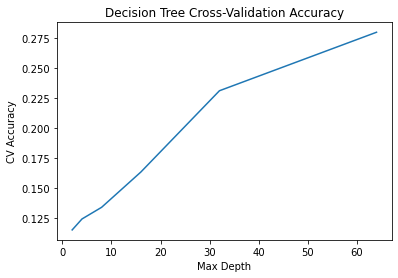

In [6]:
plt.plot(depth_values, cv_score)
plt.xlabel('Max Depth')
plt.ylabel('CV Accuracy')
plt.title('Decision Tree Cross-Validation Accuracy')

In [7]:
# Try naive Bayes 
nb_params = {}
nb_model = naive_bayes_train(train_data, train_labels, nb_params)


# Compute training accuracy
nb_train_predictions = naive_bayes_predict(train_data, nb_model)
nb_train_accuracy = np.mean(nb_train_predictions == train_labels)
print("Naive Bayes training accuracy: %f" % nb_train_accuracy)


# Compute testing accuracy
nb_test_predictions = naive_bayes_predict(test_data, nb_model)
nb_test_accuracy = np.mean(nb_test_predictions == test_labels)
print("Naive Bayes testing accuracy: %f" % nb_test_accuracy)

Naive Bayes training accuracy: 0.649763
Naive Bayes testing accuracy: 0.652750


In [8]:
# Train on full training data with best depth

best_depth_index = cv_score.argmax()

params['max_depth'] = depth_values[best_depth_index]

dt_model = decision_tree_train(train_data, train_labels, params)

In [9]:
# Compute testing accuracy

dt_predictions = decision_tree_predict(test_data, dt_model)

dt_accuracy = np.mean(dt_predictions == test_labels)

print("Decision tree testing accuracy: %f" % dt_accuracy)

Decision tree testing accuracy: 0.292000


In [11]:
# Training Perceptron algorithm
from __future__ import division
import numpy as np
import pylab as plt
from linearclassifier import linear_predict, perceptron_update, plot_predictions, log_reg_train
from scipy.io import loadmat



In [15]:
# load cardio data from MATLAB data file

variables = dict()
loadmat('processedCardio.mat', variables)

train_labels = variables['trainLabels'].ravel() - 1 # the original MATLAB data was 1-indexed
test_labels = variables['testLabels'].ravel() - 1
train_data = variables['trainData']
test_data = variables['testData']

# get data dimensions and sizes
num_dim, num_train = train_data.shape
_, num_test = test_data.shape

classes = np.unique(train_labels)
num_classes = len(classes)
print(num_classes) # meaning 10 digits

10


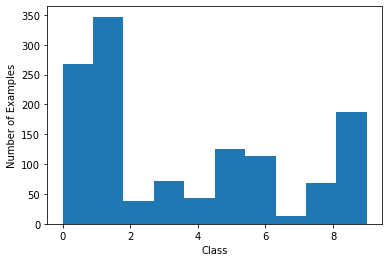

In [16]:
plt.hist(train_labels)
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.show()

In [25]:
# Perceptron experiment

epochs = 1000
lambda_val = 1

model = { 'weights': np.zeros((num_dim, num_classes)) }
params = {'lambda': lambda_val}
train_accuracy = np.zeros(epochs)
test_accuracy = np.zeros(epochs)

for epoch in range(epochs):
    # first measure training and testing accuracy
    predictions = linear_predict(train_data, model)
    train_accuracy[epoch] = np.sum(predictions == train_labels) / num_train

    predictions = linear_predict(test_data, model)
    test_accuracy[epoch] = np.sum(predictions == test_labels) / num_test

    # run perceptron training
    mistakes = 0
    for i in range(num_train):
        correct = perceptron_update(train_data[:, i], model, params, train_labels[i])
        
        if not correct:
            mistakes += 1
    
    print("Finished epoch %d with %d mistakes." % (epoch, mistakes))

Finished epoch 0 with 427 mistakes.
Finished epoch 1 with 363 mistakes.
Finished epoch 2 with 330 mistakes.
Finished epoch 3 with 308 mistakes.
Finished epoch 4 with 310 mistakes.
Finished epoch 5 with 312 mistakes.
Finished epoch 6 with 282 mistakes.
Finished epoch 7 with 287 mistakes.
Finished epoch 8 with 304 mistakes.
Finished epoch 9 with 272 mistakes.
Finished epoch 10 with 268 mistakes.
Finished epoch 11 with 265 mistakes.
Finished epoch 12 with 294 mistakes.
Finished epoch 13 with 289 mistakes.
Finished epoch 14 with 265 mistakes.
Finished epoch 15 with 276 mistakes.
Finished epoch 16 with 280 mistakes.
Finished epoch 17 with 279 mistakes.
Finished epoch 18 with 275 mistakes.
Finished epoch 19 with 274 mistakes.
Finished epoch 20 with 264 mistakes.
Finished epoch 21 with 277 mistakes.
Finished epoch 22 with 257 mistakes.
Finished epoch 23 with 245 mistakes.
Finished epoch 24 with 256 mistakes.
Finished epoch 25 with 255 mistakes.
Finished epoch 26 with 257 mistakes.
Finished ep

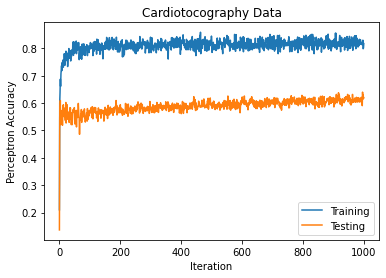

Train Accuracy: 0.817398
Test Accuracy: 0.618824


In [26]:
# Plot results of perceptron

train_line = plt.plot(range(epochs), train_accuracy, label="Training")
test_line = plt.plot(range(epochs), test_accuracy, label="Testing")
plt.title('Cardiotocography Data')
plt.xlabel('Iteration')
plt.ylabel('Perceptron Accuracy')
plt.legend()

plt.show()

print("Train Accuracy: %f" % train_accuracy[epochs-1])
print("Test Accuracy: %f" % test_accuracy[epochs-1])

In [27]:
# Logistic regression gradient check

# first check if the gradient and objective function are consistent with each other
_ = log_reg_train(train_data, train_labels, 
              {'weights': np.random.randn(num_dim * num_classes)}, check_gradient=True)

# Logistic regression experiment

model = {'weights': np.zeros((num_dim, num_classes))}
    
model = log_reg_train(train_data, train_labels, model)
        
train_predictions = linear_predict(train_data, model)
train_accuracy = np.sum(train_predictions == train_labels) / num_train

test_predictions = linear_predict(test_data, model)
test_accuracy = np.sum(test_predictions == test_labels) / num_test
    
print("Train Accuracy: %f" % train_accuracy)
print("Test Accuracy: %f" % test_accuracy)

Provided gradient differed from numerical approximation by 9.814375e-04 (should be around 1e-3 or less)
Train Accuracy: 0.899687
Test Accuracy: 0.635294


## SVM (Support Vector Machine)